In [21]:
# librairies utiles

from matplotlib import pyplot as plt
import random as rd
import numpy as np
import cv2
import os
import albumentations as A
from tqdm import tqdm

# Un dataset avec Kaggle

Au début, nous souhaitions travailler sur la langue des signes française (LSF), mais en raison de l'absence de datasets disponibles, nous nous sommes concentrés sur l'ASL. Nous avons donc cherché des datasets comprenant les 26 lettres de l'alphabet de A à Z mais aussi avec une classe vide si possible, dans laquelle on a des images sans mains. Cette dernière classe sera utile pour la traduction de vidéos. Par exemple si on ne signe plus, cela veut dire que le prochain signe appartiendra à un nouveau mot. Dans cette partie, nous présentons plusieurs datasets que nous avons étudiés, mais qui, après analyses et essais, ne nous ont pas convenu.

### dataset1  
url : https://www.kaggle.com/datasets/datamunge/sign-language-mnist  
inconvénients :   
- pas de data pour les lettres J et Z (se sont des lettres dynamiques donc plus difficiles à apprendre)
- la lettre T n'est pas signée de la même façon
- redondance d'images au sein d'une même catégorie (similitude vraiment forte voir les mêmes)

### dataset2  
url : https://www.kaggle.com/datasets/ayuraj/asl-dataset   
inconvénients :   
- redondance d'images au sein d'une même catégorie
- fond uniquement noir

### dataset3  
url : https://www.kaggle.com/datasets/lexset/synthetic-asl-alphabet   
inconvénients :   
- toutes les mains au centre des images
- même si on obtient de bons résultats sur le dataset fourni (train + test), on obtient de mauvais résultats sur nos photos pour la deuxième partie du projet (on remarque que les mains sont ajoutés aux fonds de manière artificielle, et au final il y a très peu de mains différentes par catégorie ce qui peut expliquer que le réseau ne reconnaisse pas une autre forme de mains facilement)

### dataset4 
url : https://www.kaggle.com/datasets/kapillondhe/american-sign-language   
inconvénients :   
- redondance d'images au sein d'une même catégorie, c'est presque toujours le même signe mais à des endroits différents sur l'image
- même si on obtient de bons résultats sur le dataset fourni (train + test), on obtient de mauvais résultats sur nos photos pour la deuxième partie du projet mais ausi en prenant le test d'un autre dataset

### dataset5
url : https://www.kaggle.com/datasets/kirlelea/asl-dataset-mix-static   
inconvénients : 
- pas de data pour J et pour Z   
- redondance d'images au sein d'une même catégorie, si on les enlève on passe de 3632 images dans A par exemple à environ 90 images
- même si on obtient de bons résultats sur le dataset fourni (train + test), on obtient de mauvais résultats sur nos photos pour la deuxième partie du projet car toujours ce problème de manque de diversité


**Comme nous n'avons trouvé aucun dataset vraiment exploitable pour ce projet, nous avons décidé de faire le nôtre. La partie qui suit va expliquer comment nous l'avons réalisé.**

# Un dataset maison

En faisant des recherches pour pouvoir traduire une vidéo en live ,nous sommes tombées sur le blog de David Lee (https://blog.roboflow.com/computer-vision-american-sign-language/#resources). Son objectif est un peu différent du nôtre car il fait de la traduction instantanée face à une webcam, il utilise donc un autre type de réseau de neurones qu'un CNN classique. Ses résultats étant globalement bons nous avons décidé d'utiliser son dataset initial comme base. On obtient le dataset dataASL suivant : 

📂 Contenu de dataASL 

Notre dataset dataASL contient le dossier de training data_ASL et le dossier de test data_ASL_test. Ces deux dossiers comprennent 27 sous-dossiers, les lettres de l'alphabet de "A" à "Z" plus un sous-dossier "vide" crée par nos soins. 

data_ASL : 
 - environ 700 images du dataset de David Lee
 - environ 170 images personnelles
 - environ 140 images issues de dataset1

data_ASL_test : 
 - 26 images du dataset de David Lee
 - environ 60 images personnelles
 - environ 70 images issues de dataset1

data_ASL et data_ASL_test sont téléchargeables au lien suivant : https://drive.google.com/drive/folders/1ctOHO-eZR4QXOZKiU8BzUMfJVrq8Vrv6?usp=sharing 

In [ ]:
data_ASLPath = "C:/Users/pH/Desktop/data_ASL"
data_ASL_testPath = "C:/Users/pH/Desktop/data_ASL_test"

In [17]:
def affichageData():
    """ affiche 9 images au hasard de data_ASL """

    # on récupère les différents sous dossiers
    categories = [d for d in os.listdir(data_ASLPath) if os.path.isdir(os.path.join(data_ASLPath, d))]
    if len(categories) < 1:
        print("Aucun sous-dossier trouvé dans le dossier principal.")
        return

    selected_images = []

    for _ in range(9):
        # Choisir une classe aléatoire
        choix_categorie = rd.choice(categories)
        categorie_path = os.path.join(data_ASLPath, choix_categorie)
        
        # on récupère les différentes images
        images = [f for f in os.listdir(categorie_path) if f.endswith('.jpg')]
        if not images:
            continue
        
        # Choisir une image aléatoire dans la classe
        choix_image = rd.choice(images)
        image_path = os.path.join(categorie_path, choix_image)
        selected_images.append((image_path, choix_categorie))

    # Afficher les images
    plt.figure(figsize=(10, 10))
    for i, (img_path, label) in enumerate(selected_images):
        
        # Charger l'image avec cv2
        img = cv2.imread(img_path)
        # Convertir BGR en RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Afficher l'image
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

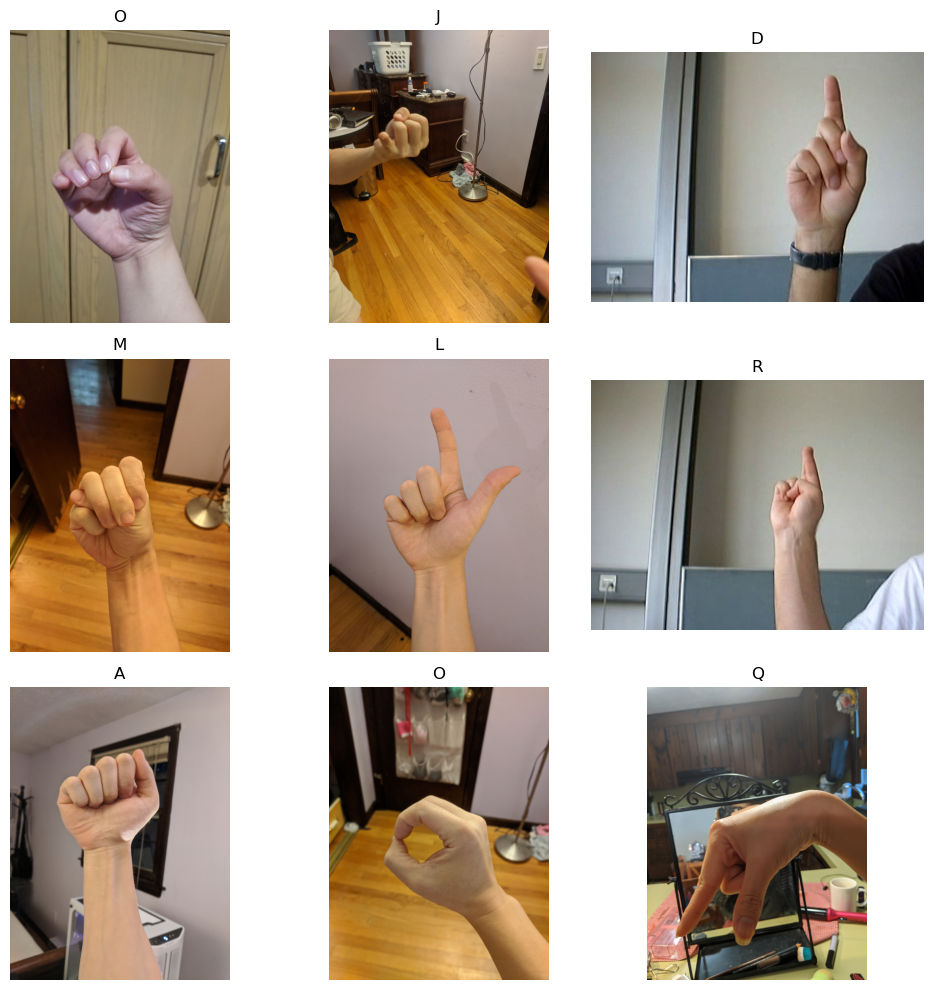

In [18]:
affichageData()

**Nous allons voir maintenant comment augmenter notre dataset et quels traitements réaliser sur les images avant de commencer notre apprentissage**

### data_ASL augmenté

On a repris le code de David Lee pour enrichir notre dataset. En effet, une trentaine d'images par catégorie n'est pas assez. On explique le rôle des différentes fonctions de la bibliothèques Albumentations qui se font au fur et à mesure (pipeline): 
 - LongestMaxSize : redimensionne l'image en conservant le ratio 
 - PadIfNeeded : ajout du padding pour s'assurer que l'image soit de la bonne taille
 - ShiftScaleRotate : on décale l'image, on agrandit ou on réduit l'image, on effectue une rotation (pas le cas ici)
 - RandomSizedCrop : on découpe un carré de l'image de taille aléatoire entre deux valeurs et on redimensionne le résultat
 - HorizontalFlip : on produit l'image miroir
 - Rotate : on effectue une rotation aléatoire selon un angle 
 - MultiplicativeNoise : on simule du bruit en multipliant la valeur des pixels par un facteur aléatoire
 - RGBShift : on modifie les couleurs
 - Blur : on floute l'image
 - RandomBrightnessContrast : on modifie le contraste et la luminosité de l'image
 - HueSaturationValue : ajuste la teinte
 - CoarseDropout : on supprime aléatoirement des zones rectangulaires de l'image
 - GaussianBlur : flou gaussien
 - ImageCompression : compression de l'image selon un pourcentage
 - MotionBlur : flou de mouvement
 - MedianBlur : flou selon un filtre médian
 - Blur : flou simple
 - Sharpen : on accentue les contours
 - Emboss : on estampe (crée du relief)
 - RandomGamma : modifie courbe gamma luminosité image
 - ToGray : on convertit image en niveau de gris
 - NoOp : on ne fait rien, on retourne l'image d'entrée

In [22]:
aug = A.Compose([
    A.LongestMaxSize(max_size=1024),
    A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0,value=(0, 0, 0), p=1.0),
    A.ShiftScaleRotate(shift_limit=.25, scale_limit=0.2, p=0.3),
    A.RandomSizedCrop((900, 1000), 1024, 1024, p=.2),
    A.HorizontalFlip(p=.5),
    A.Rotate(limit=30, p=.8),
    A.MultiplicativeNoise(p=.2),
    A.RGBShift(r_shift_limit=40, g_shift_limit=40, b_shift_limit=40, p=.3),
    A.Blur(blur_limit=25, p=.2),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.35, p=.5),
    A.HueSaturationValue(p=.3),
    A.CoarseDropout(max_holes=9, min_width=30, max_width=150, min_height=30, max_height=150, p=.2),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        A.ImageCompression(quality_lower=50, quality_upper=100, p=0.2),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1)
    ], p=0.2),
    A.OneOf([
        A.Sharpen(p=0.2),
        A.Emboss(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomGamma(gamma_limit=(50, 200), p=.2),
        A.ToGray(p=0.2)
    ], p=0.3),
    A.NoOp(p=.04)
])

C:\Users\pH\AppData\Roaming\Python\Python312\site-packages\pydantic\main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...2, 0.1568627450980392)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Voici un exemple sur une image de notre dataset : 

In [27]:
def affichageDataAugmente(augmentation, image):
    """ affiche 5 images augmentées de image avec augmentation """

    image_path = os.path.join(data_ASLPath, image)

    # Afficher les images
    plt.figure(figsize=(10, 10))
    for i in range(6):
        
        if not i :
            img = cv2.imread(image_path)
            a_afficher = img
        
        else : 
            augmented = augmentation(image=img)
            a_afficher = augmented['image']
        
        # Convertir BGR en RGB
        a_afficher = cv2.cvtColor(a_afficher, cv2.COLOR_BGR2RGB)
        
        # Afficher l'image
        plt.subplot(2, 3, i + 1)
        plt.imshow(a_afficher)
        plt.title("B")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

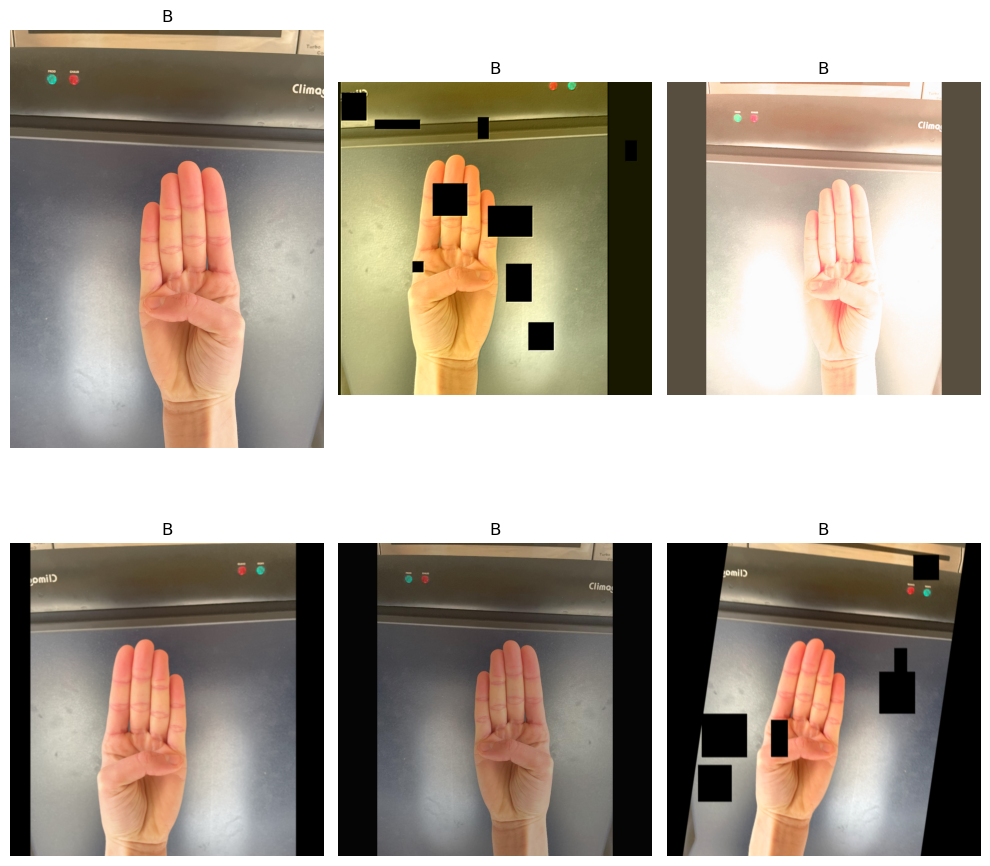

In [29]:
affichageDataAugmente(aug, "B/B30.jpg")

Il faut maintenant faire ces transformations sur toutes les images de notre dataset de training.


In [30]:
data_ASL_augPath = "C:/Users/pH/Desktop/dataASLaug"

In [31]:
def dataAugmentation(augmentation, dataInit, nbrImageAug, dataFinal):
    """ fonction qui créer le data augmenté en rajoutant à chaque image de dataInit nbrImageAug et les mets dans dataFinal"""

    # on regarde si dataFinal existe sinon on le créer
    os.makedirs(dataFinal, exist_ok=True)

    # Parcourir les dossiers et les fichiers
    for folder in os.listdir(dataInit):
        input_folder_path = os.path.join(dataInit, folder)
        output_folder_path = os.path.join(dataFinal, folder)
        os.makedirs(output_folder_path, exist_ok=True)  # Créer le dossier de sortie

        for filename in os.listdir(input_folder_path):
            file_path = os.path.join(input_folder_path, filename)
            image = cv2.imread(file_path)

            # Vérifier si l'image est correctement chargée
            if image is None:
                print(f"Erreur : Impossible de charger l'image {file_path}.")
                continue

            # Convertir en RGB pour compatibilité
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Créer nrbImageAug images augmentées
            for i in range(nbrImageAug):
                augmented = augmentation(image=image)
                augmented_image = augmented['image']

                # Sauvegarder l'image augmentée
                file_name = f'{filename[:-4]}_{i}.jpg'
                output_file_path = os.path.join(output_folder_path, file_name)
                augmented_image_bgr = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(output_file_path, augmented_image_bgr)

    # on pourra toujours enlever option enlevage de pixels

In [32]:
dataAugmentation(aug, data_ASLPath, 35, data_ASL_augPath)